In [39]:
print('hello')

hello


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px
import seaborn as sns

In [41]:
import chardet

# look at the first 100k bytes to guess the character encoding
with open("Sample-Superstore.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

# check what the character encoding might be
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [42]:
superstore = pd.read_csv('Sample-Superstore.csv', encoding='latin1')

In [43]:
# Inspect the dataset
print(superstore.head())
print(superstore.info())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

In [44]:
# Check for duplicate rows
duplicate_rows = superstore.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Optionally, display the duplicate rows
if duplicate_rows.sum() > 0:
    print(superstore[duplicate_rows])

Number of duplicate rows: 0


# Calculate Sales, Profit and Discount columns per Customer ID

In [45]:
data=superstore

In [46]:
# Group by Customer ID and aggregate relevant features for discount sensitivity analysis
customer_data = data.groupby('Customer ID').agg({
    'Discount': 'mean',   # Average discount per customer
    'Sales': 'sum',       # Total sales per customer
    'Profit': 'sum'       # Total profit per customer
}).reset_index()


In [47]:
# Select relevant features
discount_sensitivity_features = customer_data[['Customer ID','Discount', 'Sales', 'Profit']]

In [48]:
# Check for missing values
print(discount_sensitivity_features.isnull().sum())

Customer ID    0
Discount       0
Sales          0
Profit         0
dtype: int64


In [49]:

# Inspect RFM table
print(discount_sensitivity_features.head())

  Customer ID  Discount     Sales    Profit
0    AA-10315  0.090909  5563.560 -362.8825
1    AA-10375  0.080000  1056.390  277.3824
2    AA-10480  0.016667  1790.512  435.8274
3    AA-10645  0.063889  5086.935  857.8033
4    AB-10015  0.066667   886.156  129.3465


## Checking for Outliers

In [50]:
# Detect and remove outliers using the IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers = pd.concat([detect_outliers(discount_sensitivity_features, col) for col in ['Discount', 'Sales', 'Profit']]).drop_duplicates()
discount_sensitivity_features = discount_sensitivity_features[~discount_sensitivity_features.index.isin(outliers.index)]


In [51]:
discount_sensitivity_features.shape

(695, 4)

## Scaling

In [52]:
# Normalize the features
scaler = StandardScaler()
discount_sensitivity_normalized = scaler.fit_transform(discount_sensitivity_features[['Sales', 'Profit', 'Discount']])


In [53]:
print(discount_sensitivity_normalized)

[[ 2.10997555e+00 -1.74604032e+00 -7.83672998e-01]
 [-7.93394672e-01 -7.38211503e-04 -9.19064879e-01]
 [-3.20497498e-01  4.31168008e-01 -1.70508997e+00]
 ...
 [ 5.57900850e-02  9.36558118e-01 -1.33571728e+00]
 [ 2.03962607e+00  2.80216565e+00 -9.81119492e-01]
 [-5.11536820e-01 -7.77496977e-02 -5.32947292e-01]]


# The Model

## Determin the optimal number of clusters using the elbow method

In [54]:
from sklearn.metrics import silhouette_score

c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 2, the average silhouette_score is : 0.3599021573382531


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 3, the average silhouette_score is : 0.3269508482964207


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 4, the average silhouette_score is : 0.30920788699151375


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 5, the average silhouette_score is : 0.29304703813219485


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 6, the average silhouette_score is : 0.28782824863203266


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 7, the average silhouette_score is : 0.282873488636161


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 8, the average silhouette_score is : 0.2893641149091299


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 9, the average silhouette_score is : 0.2835028594364497


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 10, the average silhouette_score is : 0.2818807785972777


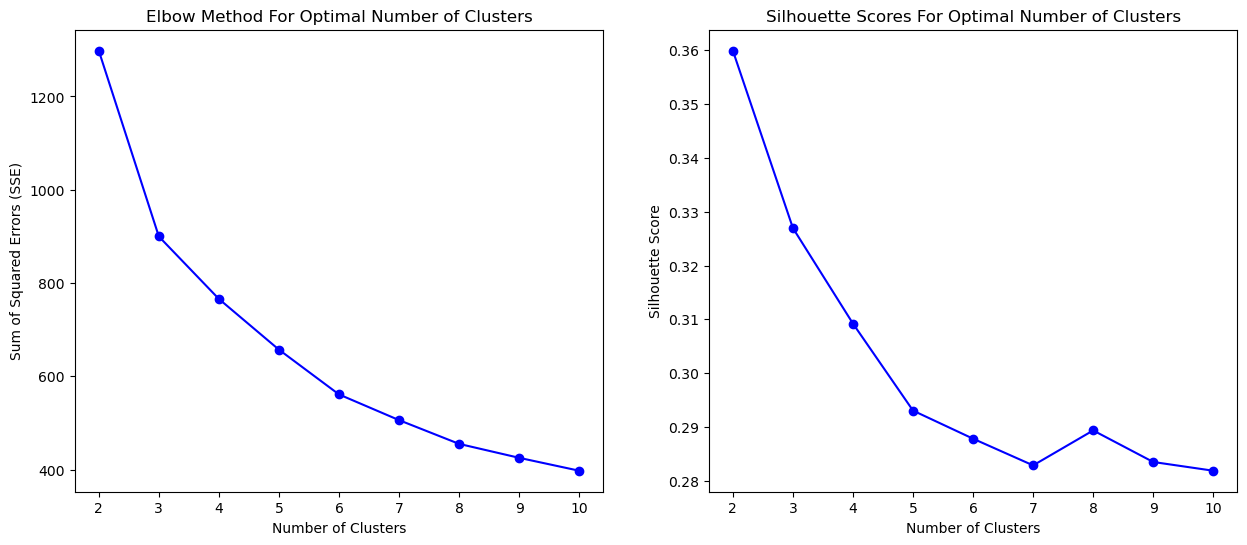

In [55]:
# Determine the optimal number of clusters using the elbow method and silhouette score
sse = {}
silhouette_scores = []
range_n_clusters = list(range(2, 11))

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(discount_sensitivity_normalized)
    sse[k] = kmeans.inertia_
    silhouette_avg = silhouette_score(discount_sensitivity_normalized, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

# Plot the elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow Method
ax1.plot(list(sse.keys()), list(sse.values()), 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Sum of Squared Errors (SSE)')
ax1.set_title('Elbow Method For Optimal Number of Clusters')

# Silhouette Scores
ax2.plot(range_n_clusters, silhouette_scores, 'bo-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores For Optimal Number of Clusters')

plt.show()

In [56]:
# we determine that 3 is the best choice

In [59]:
# Choose and fit KMeans for k=2, k=3, and k=8
optimal_k1 = 2
optimal_k2 = 3
optimal_k3 = 8



In [70]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


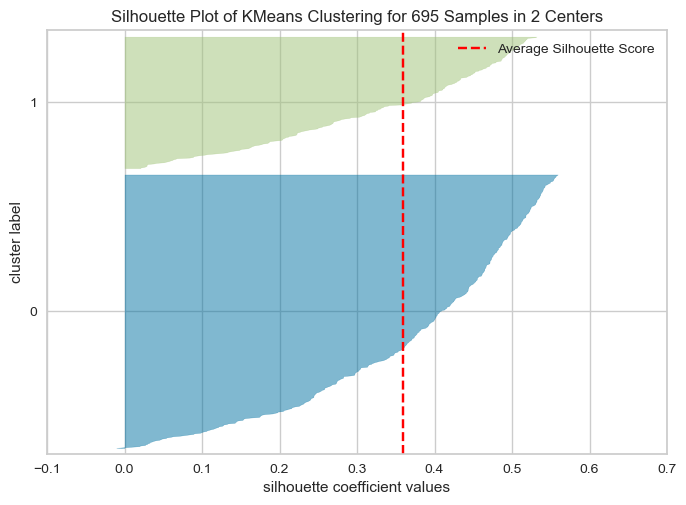

Average silhouette score is : 0.3599021573382531


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


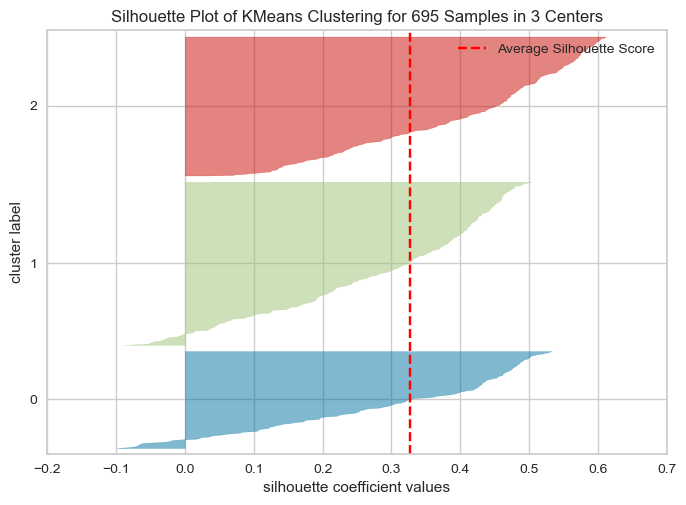

Average silhouette score is : 0.3269508482964207


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


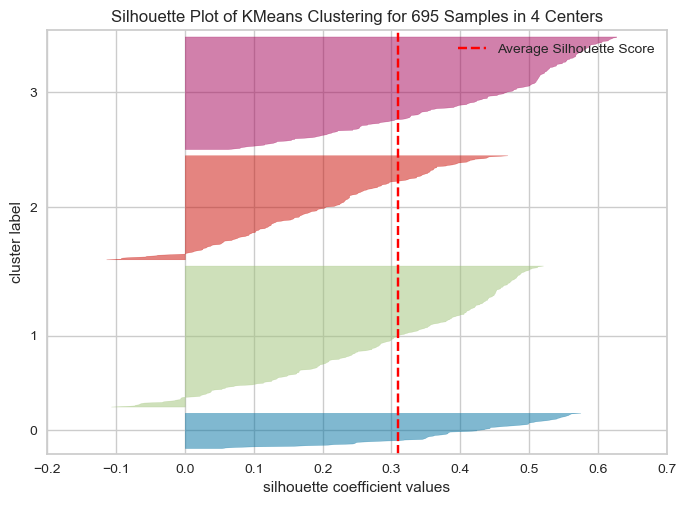

Average silhouette score is : 0.30920788699151375


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


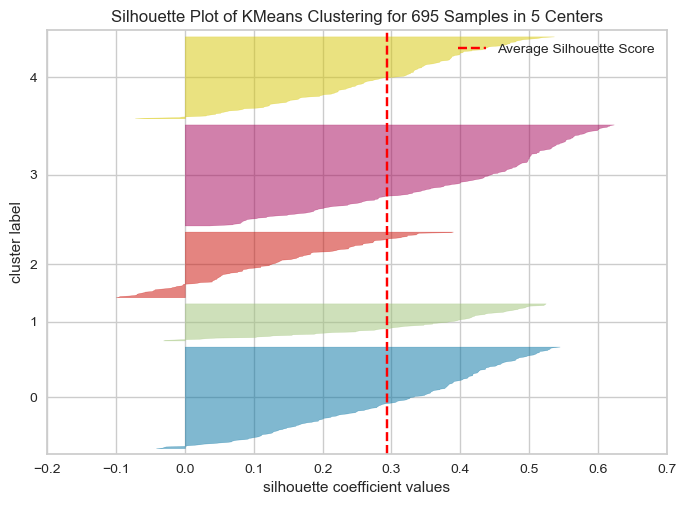

Average silhouette score is : 0.29304703813219485


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


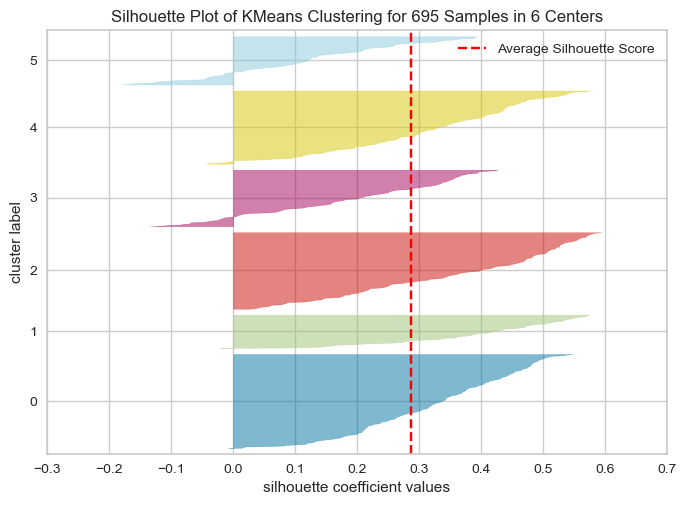

Average silhouette score is : 0.28782824863203266


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


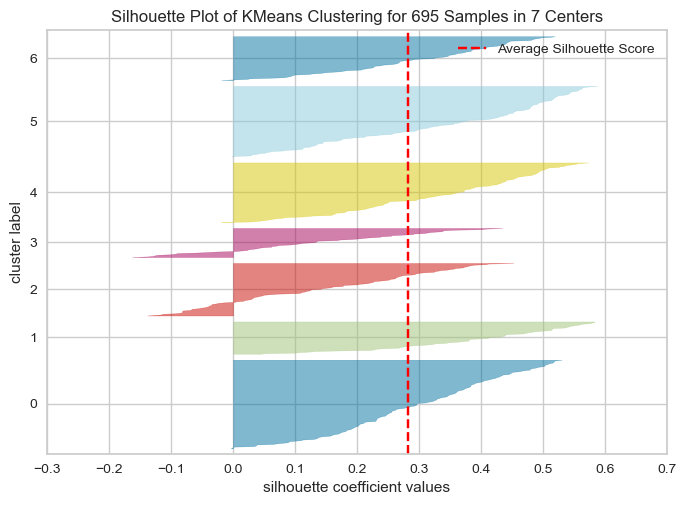

Average silhouette score is : 0.282873488636161


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


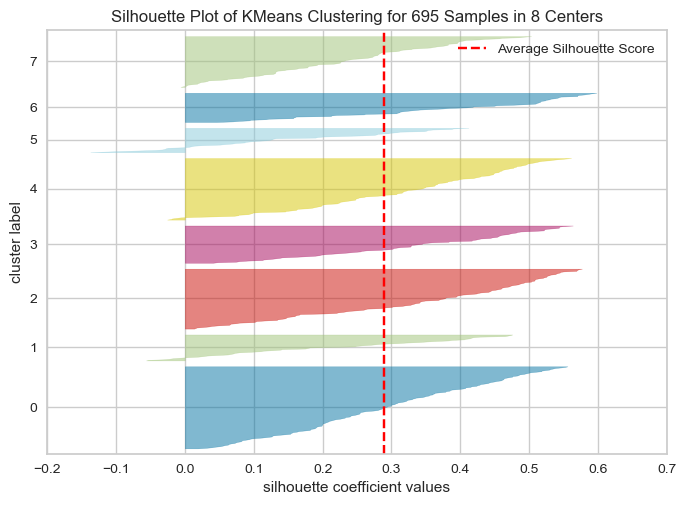

Average silhouette score is : 0.2893641149091299


In [71]:
# Load a clustering dataset
X = discount_sensitivity_normalized
# Create a range of values for k
k_range = range(2, 9)
 
 
# Fit and plot the data for each k value
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figur
     # Compute the average silhouette score
    silhouette_avg = silhouette_score(X, y_kmeans)
    print('Average silhouette score is :' , silhouette_avg)

## Fit the model

## K=2

In [60]:
kmeans = KMeans(n_clusters=optimal_k1, random_state=42)

In [61]:
discount_sensitivity_features['Cluster'] = kmeans.fit_predict(discount_sensitivity_normalized)

c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


### Plots

<Axes: xlabel='Cluster', ylabel='Profit'>

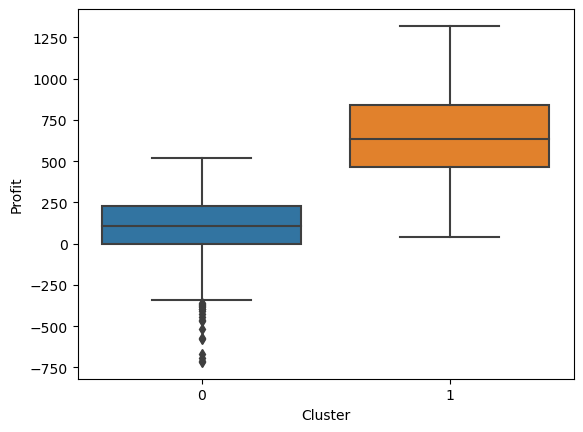

In [64]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster', y='Profit', data=discount_sensitivity_features)

<Axes: xlabel='Cluster', ylabel='Sales'>

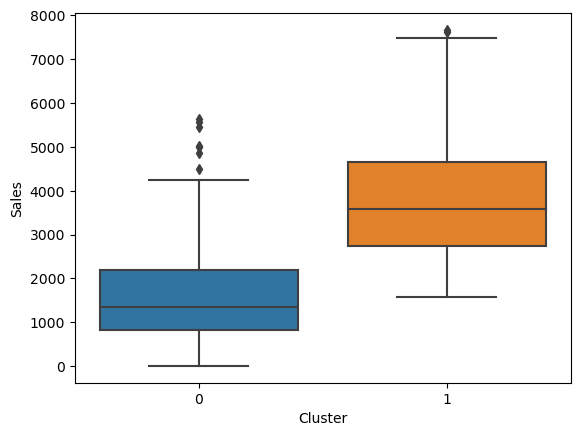

In [66]:
# Box plot to visualize Cluster Id vs Sales
sns.boxplot(x='Cluster', y='Sales', data=discount_sensitivity_features)

<Axes: xlabel='Cluster', ylabel='Discount'>

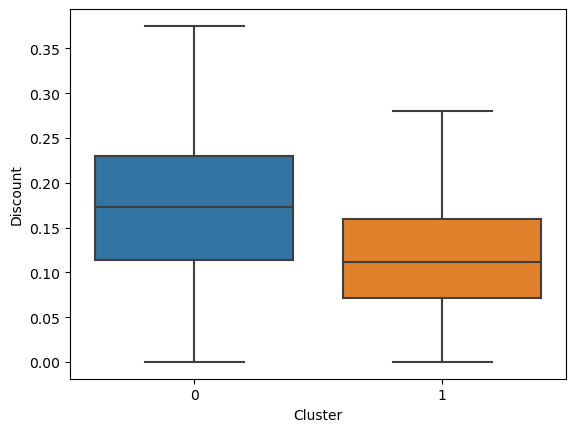

In [67]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster', y='Discount', data=discount_sensitivity_features)

## Analyse the clusters

In [68]:
cluster_analysis = discount_sensitivity_features[['Profit', 'Sales', 'Discount', 'Cluster']].groupby('Cluster').mean().reset_index()
print(cluster_analysis)

   Cluster      Profit        Sales  Discount
0        0   85.488051  1558.408664  0.172136
1        1  676.438438  3802.216871  0.116526


c:\Users\gabb_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


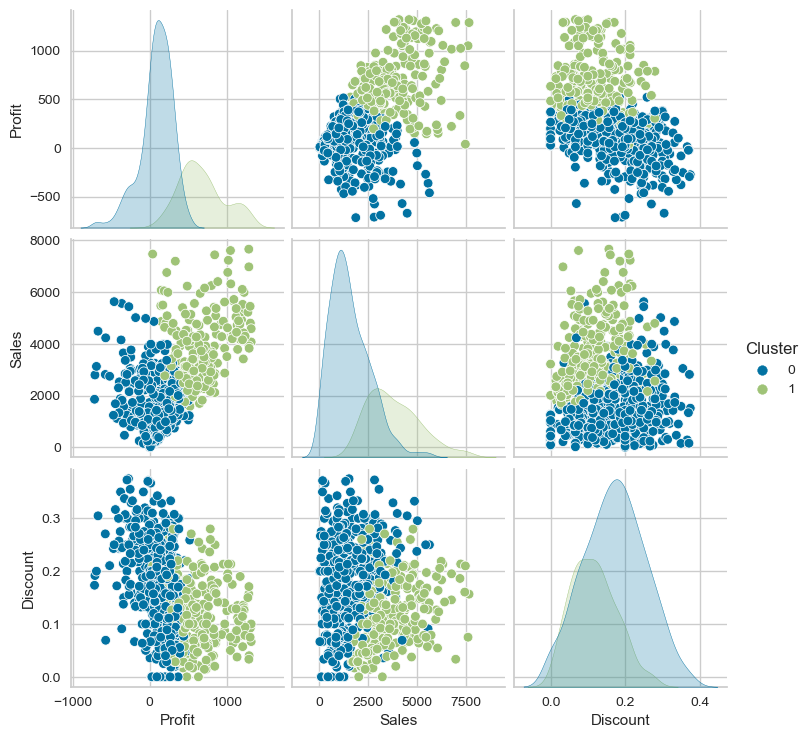

In [74]:
# Visualize clusters
sns.pairplot(discount_sensitivity_features, hue='Cluster', vars=['Profit', 'Sales', 'Discount'])
plt.show()

In [ ]:
#Optional clusters:
#Summary of Clusters:
#Loyal Customers: Frequent, recent purchasers who spend a lot.
#At-Risk Customers: Past big spenders who haven’t purchased recently.
#New Customers: Recent purchasers with few transactions and moderate spending.
#Potential Loyalists: Recent, occasional purchasers with moderate spending.
#Big Spenders: Customers who spend a lot but may not be frequent or recent.
#Lost Customers: Infrequent purchasers who haven’t bought anything in a long time and spend little.

In [125]:


# 3D Scatter Plot using Plotly Express for k=2 with customizations
fig = px.scatter_3d(discount_sensitivity_features, x='Discount', y='Sales', z='Profit', color='Cluster',
                    title=f'3D Scatter Plot of Discount Sensitivity Clusters',
                    labels={'Discount': 'Discount', 'Sales': 'Sales', 'Profit': 'Profit'},
                    hover_data=['Customer ID', 'Discount', 'Sales', 'Profit'],
                    color_continuous_scale=['skyblue', 'yellow'])

# Update layout for background color and marker properties
fig.update_layout(
    scene=dict(
        xaxis=dict(backgroundcolor="black"),
        yaxis=dict(backgroundcolor="black"),
        zaxis=dict(backgroundcolor="black"),
    ),
    paper_bgcolor="black",
    plot_bgcolor="black",
    font=dict(color='white'),
    width=1200,  # Increase width
    height=800  # Increase height
)

# Update marker properties
fig.update_traces(marker=dict(size=5, opacity=0.5))

# Show the plot
fig.show()